<a href="https://colab.research.google.com/github/akkified/stroke-classification/blob/main/stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50 # Or ResNet50V2, ResNet101, etc.
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report # New imports for evaluation
import seaborn as sns # New import for better confusion matrix visualization

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

DATASET_ROOT = '/content/drive/MyDrive/stroke-dataset'


TRAIN_DIR = os.path.join(DATASET_ROOT, 'train')
VALIDATION_DIR = os.path.join(DATASET_ROOT, 'valid')
TEST_DIR = os.path.join(DATASET_ROOT, 'test')


IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [ ]:
print("\nLoading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical', # For multi-class classification (one-hot encoded)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest', # Good for medical images to preserve pixel values
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle training data
)

print("\nLoading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

print("\nLoading test data...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle test data
)

# Get the class names from the dataset (e.g., ['hemorrhagic_stroke', 'ischemic_stroke', 'no_stroke'])
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(f"\nDetected Class Names: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")


Loading training data...
Found 2000 files belonging to 3 classes.

Loading validation data...
Found 217 files belonging to 3 classes.

Loading test data...
Found 131 files belonging to 3 classes.

Detected Class Names: ['hemorrhagic_stroke', 'ischemic_stroke', 'no_stroke']
Number of Classes: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = False


inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.2),
])
x = data_augmentation(inputs)

x = base_model(x, training=False) # Set training=False to keep base model layers frozen

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x) # Dropout helps prevent overfitting

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("\nResNet model defined and compiled for initial training!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


ResNet model defined and compiled for initial training!


In [ ]:
INITIAL_EPOCHS = 10

print(f"\nStarting initial model training for {INITIAL_EPOCHS} epochs...")
history = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds
)

print("\nInitial model training complete!")


Starting initial model training for 10 epochs...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.5311 - loss: 1.1372 - val_accuracy: 0.7281 - val_loss: 0.6198
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7915 - loss: 0.5171 - val_accuracy: 0.7650 - val_loss: 0.5083
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.8280 - loss: 0.4081 - val_accuracy: 0.8018 - val_loss: 0.4511
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8599 - loss: 0.3560 - val_accuracy: 0.8571 - val_loss: 0.3609
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.8954 - loss: 0.2779 - val_accuracy: 0.8710 - val_loss: 0.3200
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9022 - loss: 0.2573 - val_accuracy: 0.8756 - val_loss: 0.2944
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9158 - loss: 0.2317 - val_accuracy: 0.9032 - val_loss: 0.2720
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step

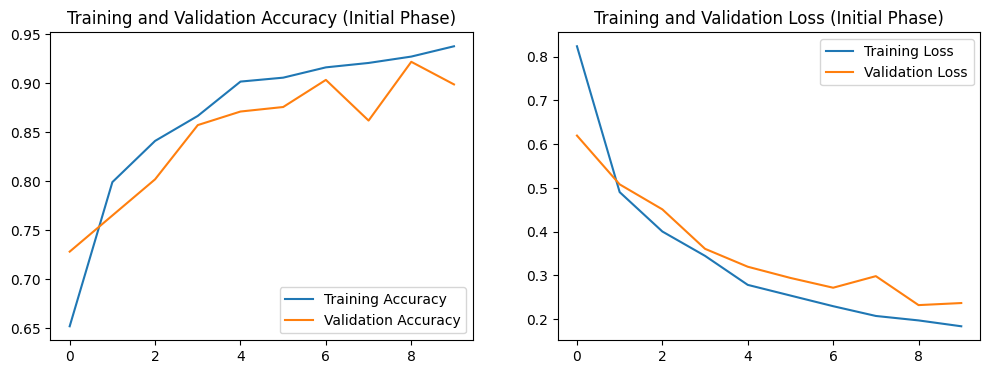


Initial training history plots displayed.


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(INITIAL_EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Initial Phase)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Initial Phase)')
plt.show()

print("\nInitial training history plots displayed.")


In [ ]:
print("\nEvaluating model on the test set (after initial training)...")
initial_test_loss, initial_test_accuracy = model.evaluate(test_ds)

print(f"\nTest Loss (Initial): {initial_test_loss:.4f}")
print(f"Test Accuracy (Initial): {initial_test_accuracy:.4f}")

print("\nInitial model evaluation complete!")


Evaluating model on the test set (after initial training)...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8590 - loss: 0.3151

Test Loss (Initial): 0.2491
Test Accuracy (Initial): 0.8855

Initial model evaluation complete!


In [ ]:
print("\n--- Starting Fine-tuning Phase ---")
# Unfreeze the base model layers
base_model.trainable = True

# It's important to recompile the model after unfreezing layers.
# Use a very low learning rate for fine-tuning to avoid destroying learned weights.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Very small learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary() # See how many parameters are now trainable

FINE_TUNE_EPOCHS = 10 # Number of additional epochs for fine-tuning
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

print(f"\nStarting fine-tuning for {FINE_TUNE_EPOCHS} additional epochs...")

# Continue training from where it left off
history_fine_tune = model.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS, # Start from the epoch where initial training ended
    validation_data=val_ds
)

print("\nFine-tuning complete!")


--- Starting Fine-tuning Phase ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 23,797,251 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


Starting fine-tuning for 10 additional epochs...
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 583ms/step - accuracy: 0.7728 - loss: 0.5508 - val_accuracy: 0.8894 - val_loss: 0.2781
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - accuracy: 0.9052 - loss: 0.2522 - val_accuracy: 0.9124 - val_loss: 0.2590
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 514ms/step - accuracy: 0.9545 - loss: 0.1401 - val_accuracy: 0.8940 - val_loss: 0.2669
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 513ms/step - accuracy: 0.9740 - loss: 0.0912 - val_accuracy: 0.8802 - val_loss: 0.2936
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.9847 - loss: 0.0611 - val_accuracy: 0.8664 - val_loss: 0.3008
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.9896 - loss: 0.0448 - val_accuracy: 0.8618 - val_loss: 0.2972
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.9909 - loss: 0.0330 - val_accuracy: 0.8940 - val_loss: 0.2372
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3

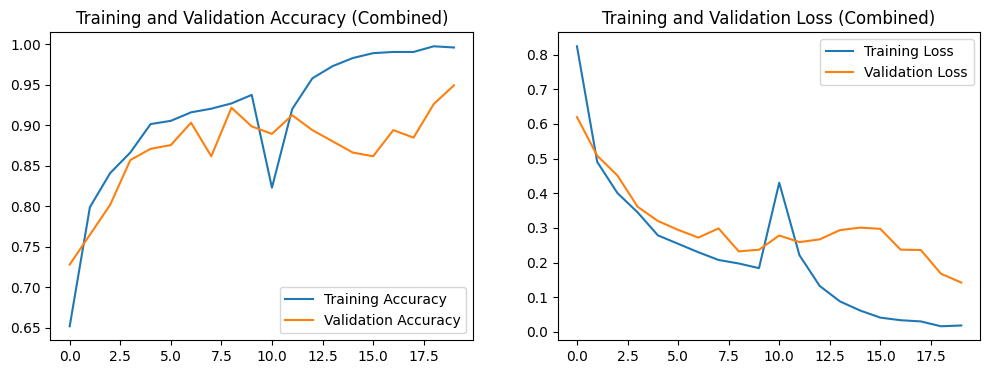


Combined training history plots displayed.


In [ ]:
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

if not (len(acc) == len(val_acc) == len(loss) == len(val_loss)):
    print("Error: Inconsistent lengths in history lists after combination.")
    print(f"Lengths: acc={len(acc)}, val_acc={len(val_acc)}, loss={len(loss)}, val_loss={len(val_loss)}")
    print("This usually indicates that the training cells were run multiple times without restarting the runtime, causing history objects to accumulate inconsistently.")
    print("Please restart the Google Colab runtime (`Runtime > Restart session`) and run all cells from the beginning.")
else:
    TOTAL_EPOCHS_ACTUAL = len(acc)

    epochs_range_combined = range(TOTAL_EPOCHS_ACTUAL)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range_combined, acc, label='Training Accuracy')
    plt.plot(epochs_range_combined, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Combined)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range_combined, loss, label='Training Loss')
    plt.plot(epochs_range_combined, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Combined)')
    plt.show()

    print("\nCombined training history plots displayed.")


In [ ]:
print("\nEvaluating model on the test set (after fine-tuning)...")
loss_fine_tune, accuracy_fine_tune = model.evaluate(test_ds)

print(f"\nTest Loss (Fine-tuned): {loss_fine_tune:.4f}")
print(f"Test Accuracy (Fine-tuned): {accuracy_fine_tune:.4f}")

print("\nModel training and evaluation complete!")
print("You now have a fine-tuned ResNet model for stroke classification!")


Evaluating model on the test set (after fine-tuning)...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9016 - loss: 0.3768 

Test Loss (Fine-tuned): 0.2717
Test Accuracy (Fine-tuned): 0.9237

Model training and evaluation complete!
You now have a fine-tuned ResNet model for stroke classification!


In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/stroke_classification_model.h5'


print(f"\nSaving the trained model to: {MODEL_SAVE_PATH}...")
try:
    model.save(MODEL_SAVE_PATH)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")
    print("If saving to Google Drive, ensure it's mounted and you have write permissions.")


Saving the trained model to: /content/drive/MyDrive/stroke_classification_model.h5...
Model saved successfully!



Generating Confusion Matrix and Classification Report...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


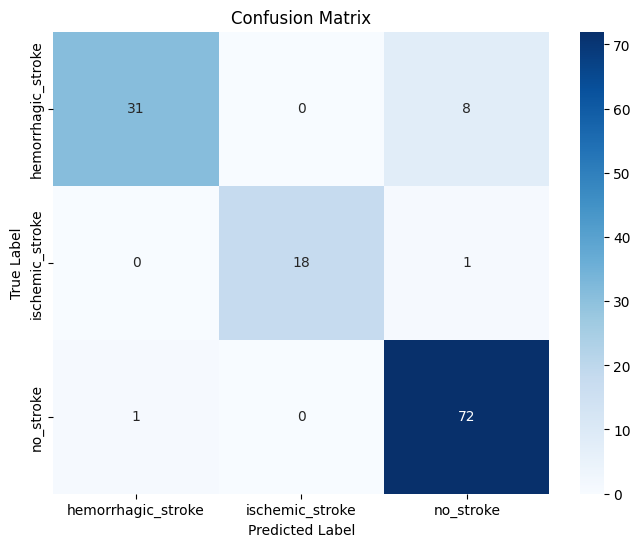


Classification Report:
                    precision    recall  f1-score   support

hemorrhagic_stroke       0.97      0.79      0.87        39
   ischemic_stroke       1.00      0.95      0.97        19
         no_stroke       0.89      0.99      0.94        73

          accuracy                           0.92       131
         macro avg       0.95      0.91      0.93       131
      weighted avg       0.93      0.92      0.92       131


Confusion Matrix and Classification Report generated.
This provides a detailed breakdown of your model's performance per class.


In [ ]:
print("\nGenerating Confusion Matrix and Classification Report...")

true_labels = []
for _, labels in test_ds:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())

predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1).numpy()


true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


if len(true_labels) != len(predicted_labels):
    print(f"Warning: Mismatch in length of true labels ({len(true_labels)}) and predicted labels ({len(predicted_labels)}).")
    print("This can happen if the test_ds was shuffled or processed differently during prediction.")
    print("Please ensure test_ds.shuffle=False and batch_size is consistent.")
else:
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES))

print("\nConfusion Matrix and Classification Report generated.")
print("This provides a detailed breakdown of your model's performance per class.")



--- Step 15: Make a Prediction on a New Image ---


Model loaded successfully from /content/drive/MyDrive/stroke_classification_model.h5
Making prediction for: stroke.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prediction for 'stroke.png':
  Predicted Class: ischemic_stroke
  Confidence: 100.00%
  All Probabilities: [1.5377167e-05 9.9997473e-01 9.8955579e-06]


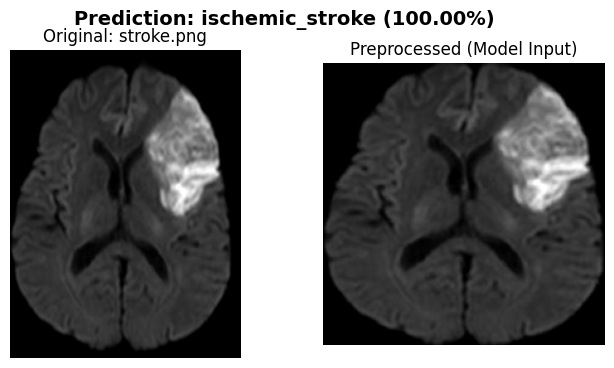


Prediction complete for the new image.


In [45]:
# IMPORTANT: You need to upload your test image to Google Colab's temporary storage
# (e.g., drag and drop it into the file browser on the left sidebar)
# or specify a path on Google Drive if mounted.
NEW_IMAGE_PATH = '/content/stroke.png' # <--- CHANGE THIS TO YOUR IMAGE PATH

def preprocess_single_image(image_path, target_size=(224, 224), pixel_threshold=40):
    """
    Preprocesses a single image for prediction, including auto-cropping and resizing.
    This function is similar to the one used in your initial preprocessing script.
    """
    try:
        # Explicitly use PIL.Image
        img = Image.open(image_path).convert("L") # Convert to grayscale
        original_width, original_height = img.size
        data = np.array(img)

        rows_with_content = np.any(data > pixel_threshold, axis=1)
        cols_with_content = np.any(data > pixel_threshold, axis=0)

        try:
            min_row = np.where(rows_with_content)[0][0]
            max_row = np.where(rows_with_content)[0][-1]
            min_col = np.where(cols_with_content)[0][0]
            max_col = np.where(cols_with_content)[0][-1]
        except IndexError:
            # Fallback if no content found
            print(f"Warning: No content found for auto-cropping in {os.path.basename(image_path)}. Resizing without crop.")
            cropped_img = img
        else:
            buffer = 5
            min_row = max(0, min_row - buffer)
            max_row = min(original_height - 1, max_row + buffer)
            min_col = max(0, min_col - buffer)
            max_col = min(original_width - 1, max_col + buffer)
            cropped_img = img.crop((min_col, min_row, max_col + 1, max_row + 1))

        processed_img = cropped_img.resize(target_size, Image.LANCZOS) # Explicitly use Image.LANCZOS

        # Convert to RGB as ResNet expects 3 channels
        if processed_img.mode == 'L':
            processed_img = processed_img.convert('RGB')

        # Convert to numpy array and add batch dimension
        img_array = keras.utils.img_to_array(processed_img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch
        return img_array

    except Exception as e:
        print(f"Error processing single image {image_path}: {e}")
        return None

print("\n--- Step 15: Make a Prediction on a New Image ---")

# Load the saved model
try:
    # Ensure the path matches where you saved your model in Step 13
    loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print(f"Model loaded successfully from {MODEL_SAVE_PATH}")

    # Check if the new image path exists
    if not os.path.exists(NEW_IMAGE_PATH):
        print(f"Error: New image path '{NEW_IMAGE_PATH}' does not exist.")
        print("Please upload your image to Colab or provide the correct path.")
    else:
        # Preprocess the new image
        processed_image = preprocess_single_image(NEW_IMAGE_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH))

        if processed_image is not None:
            # Make a prediction
            print(f"Making prediction for: {os.path.basename(NEW_IMAGE_PATH)}")
            predictions = loaded_model.predict(processed_image)

            # Get the predicted class and its probability
            predicted_class_index = np.argmax(predictions[0])
            predicted_class_name = CLASS_NAMES[predicted_class_index]
            confidence = np.max(predictions[0]) * 100

            print(f"\nPrediction for '{os.path.basename(NEW_IMAGE_PATH)}':")
            print(f"  Predicted Class: {predicted_class_name}")
            print(f"  Confidence: {confidence:.2f}%")
            print(f"  All Probabilities: {predictions[0]}") # NEW: Show all probabilities for debugging

            # Display the image and prediction
            plt.figure(figsize=(8,4)) # Adjusted figure size for two plots

            plt.subplot(1, 2, 1) # Original image
            plt.imshow(Image.open(NEW_IMAGE_PATH).convert('RGB'))
            plt.title(f"Original: {os.path.basename(NEW_IMAGE_PATH)}")
            plt.axis('off')

            plt.subplot(1, 2, 2) # Preprocessed image
            # The processed_image is a TensorFlow tensor, convert to numpy for imshow
            plt.imshow(processed_image[0].numpy().astype(np.uint8))
            plt.title(f"Preprocessed (Model Input)")
            plt.axis('off')

            plt.suptitle(f"Prediction: {predicted_class_name} ({confidence:.2f}%)", fontsize=14, fontweight='bold')
            plt.show()

            print("\nPrediction complete for the new image.")
        else:
            print("Could not process the new image for prediction.")

except Exception as e:
    print(f"Error loading model or making prediction: {e}")
    print("Ensure the model was saved correctly and the image path is valid.")
